In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import torch
import torch.utils.data as data
import torch.nn.functional as F

from adabelief_pytorch import AdaBelief

from models import LTVAE, torch_dataloader, torch_latent_dataloader
import utils as ut

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set Seeds
torch.manual_seed(0)
np.random.seed(0)

LATENT_DIM = 2

/var/folders/n7/b5dt_rrd5dv7z7wz4pl21bzc0000gn/T/ipykernel_95340/3179836869.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Train/Test Sizes: 3200 800


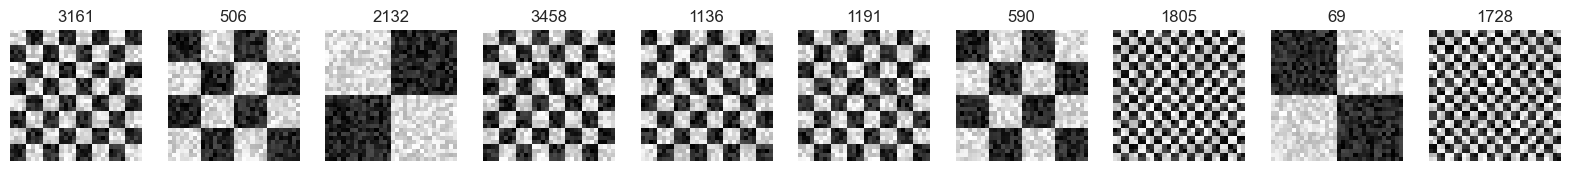

In [5]:
x = ut.make_checker_dataset(N=500,image_dim=32,checker_sizes=[16,8,4,2],flipped=True,low=0.3,high=0.7)
train_set, test_set = torch.utils.data.random_split(torch_dataloader(x), [int(0.8*len(x)), len(x)-int(0.8*len(x))])
train_loader = data.DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = data.DataLoader(test_set, batch_size=100, shuffle=True)
print('Train/Test Sizes:', len(train_set), len(test_set))
ut.plot_images(x,10,32)

Number of Parameters: 321911
Epoch: 0/100, Total Loss: 61073.5179, KLD: 520.3307 Reconstruction: 60553.1869 Test Loss: 755.97714844
Epoch: 5/100, Total Loss: 44394.3756, KLD: 725.6850 Reconstruction: 43668.6907 Test Loss: 494.24128418
Epoch: 10/100, Total Loss: 44112.6417, KLD: 613.6580 Reconstruction: 43498.9836 Test Loss: 488.50635742
Epoch: 15/100, Total Loss: 44051.5845, KLD: 570.9455 Reconstruction: 43480.6390 Test Loss: 480.70712402
Epoch: 20/100, Total Loss: 43999.0507, KLD: 549.4682 Reconstruction: 43449.5825 Test Loss: 483.13474609
Epoch: 25/100, Total Loss: 43966.5076, KLD: 530.0992 Reconstruction: 43436.4081 Test Loss: 486.25740723
Epoch: 30/100, Total Loss: 43956.8619, KLD: 523.4834 Reconstruction: 43433.3782 Test Loss: 491.19801758
Epoch: 35/100, Total Loss: 43956.7639, KLD: 513.6132 Reconstruction: 43443.1504 Test Loss: 480.78872070
Epoch: 40/100, Total Loss: 43929.3383, KLD: 506.8145 Reconstruction: 43422.5242 Test Loss: 481.99469238
Epoch: 45/100, Total Loss: 43949.0154

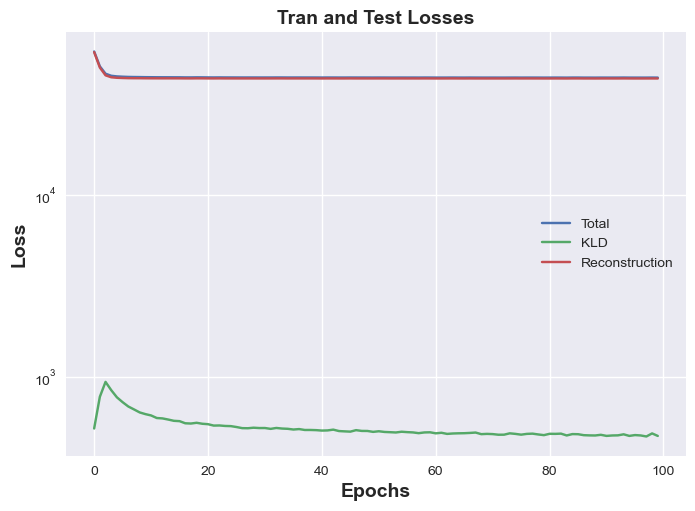

In [6]:
# Train Variabls
EPOCHS = 100

# Model
model = LTVAE(latent_dim=LATENT_DIM).to(device)

# Print Number of Parameters
print('Number of Parameters: {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# Optimizer
optimizer = optimizer = AdaBelief(model.parameters(),lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = False, rectify = False,print_change_log = False)

# Loss Reconstruction
loss_fn = torch.nn.MSELoss()

# Store Losses
losses = {'KLD':[], 
          'Reconstruction':[],
          'Total':[]}


# Train
for epoch in range(EPOCHS):
    model.train()

    # Losses
    losses['KLD'].append(0)
    losses['Reconstruction'].append(0)
    losses['Total'].append(0)

    for idx, x in enumerate(train_loader):

        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2]).to(device)
        optimizer.zero_grad()

        x_hat, mu, logvar = model(x)

        loss_KLD = ut.vae_KLD(mu,logvar)
        loss_recon = ut.vae_recon_loss(x, x_hat)
        loss = loss_KLD + loss_recon
        loss.backward()
        optimizer.step()

        losses['KLD'][-1] += loss_KLD.item()
        losses['Reconstruction'][-1] += loss_recon.item()
        losses['Total'][-1] += loss.item()

    # Divide lossed by number of batches
    losses['KLD'][-1] /= len(train_loader)
    losses['Reconstruction'][-1] /= len(train_loader)
    losses['Total'][-1] /= len(train_loader)

    # Test
    test_loss = ut.test(model, test_loader, device)
        
    if epoch % 5 == 0:
        print('Epoch: {}/{},'.format(epoch, EPOCHS),
                'Total Loss: {:.4f},'.format(losses['Total'][-1]),
                'KLD: {:.4f}'.format(losses['KLD'][-1]),
                'Reconstruction: {:.4f}'.format(losses['Reconstruction'][-1]),
                'Test Loss: {:.8f}'.format(test_loss),
                )

plt.plot(losses['Total'], label='Total')
plt.plot(losses['KLD'], label='KLD')
plt.plot(losses['Reconstruction'], label='Reconstruction')
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Tran and Test Losses', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend()

Train Size:  2000


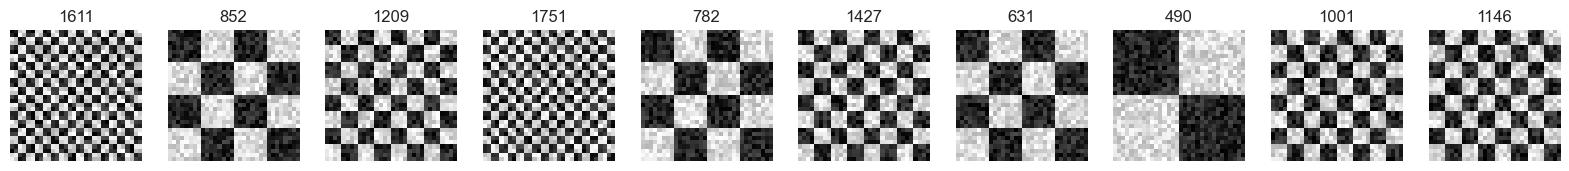

In [7]:
# Flip trainer
x = ut.make_checker_dataset(N=500,image_dim=32,checker_sizes=[16,8,4,2],flipped=False,low=0.3,high=0.7)
x_test = torch.flip(x, dims=[2])
print('Train Size: ', x.shape[0])
ut.plot_images(x,n_images=10)
# Data loaders
train_loader = data.DataLoader(torch_latent_dataloader(x,x_test), batch_size=100, shuffle=False)

In [8]:
# Train Variables
EPOCHS = 50

# Loss Reconstruction
loss_fn = torch.nn.MSELoss()

# Store Losses
losses = []

# Train
for epoch in range(EPOCHS):

    # Losses
    losses.append(0)

    for idx, (x,x_flip) in enumerate(train_loader):

        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2]).to(device)
        x_flip = x_flip.reshape(x_flip.shape[0],1,x_flip.shape[1],x_flip.shape[2]).to(device)

        with torch.no_grad():
            model.eval()
            _,z,_ = model(x)
            _,z_flip,_ = model(x_flip)

        model.train()

        optimizer.zero_grad()
        z_hat_flip = model.Laug(z)

        loss = loss_fn(z_hat_flip, z_flip)
        loss.backward()
        optimizer.step()

        losses[-1] += loss.item()

    # Divide lossed by number of batches
    losses[-1] /= len(train_loader)

    # Test
    test_loss = ut.test_flip(model, train_loader, device)
        
    if epoch % 5 == 0:
        print('Epoch: {}/{},'.format(epoch, EPOCHS),
                'Loss: {:.4f},'.format(losses[-1]),
                'Test Loss: {:.8f}'.format(test_loss),
                )



Epoch: 0/50, Loss: 1.4428, Test Loss: 1612.74953906
Epoch: 5/50, Loss: 0.9635, Test Loss: 1601.79594531
Epoch: 10/50, Loss: 0.5580, Test Loss: 1601.79585156
Epoch: 15/50, Loss: 0.2594, Test Loss: 1601.79585156
Epoch: 20/50, Loss: 0.1214, Test Loss: 1601.79585156
Epoch: 25/50, Loss: 0.0628, Test Loss: 1601.79585156
Epoch: 30/50, Loss: 0.0314, Test Loss: 1601.79585156
Epoch: 35/50, Loss: 0.0144, Test Loss: 1601.79585156
Epoch: 40/50, Loss: 0.0055, Test Loss: 1601.79585156
Epoch: 45/50, Loss: 0.0018, Test Loss: 1601.79585156


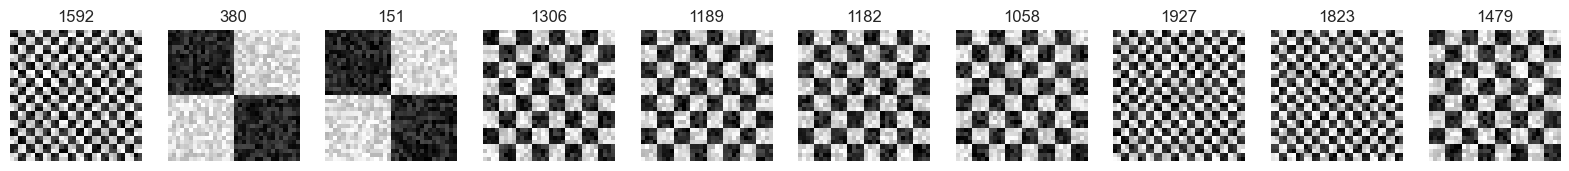

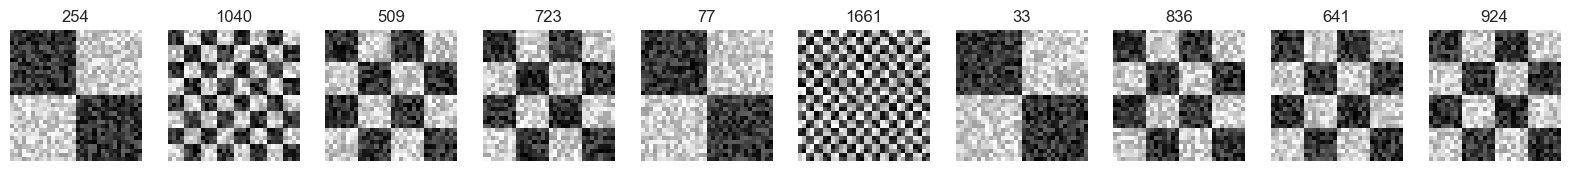

In [16]:
x_train = ut.make_checker_dataset(N=500,image_dim=32,checker_sizes=[16,8,4,2],flipped=False,low=0.3,high=0.7)
x_test = ut.make_checker_dataset(N=500,image_dim=32,checker_sizes=[16,8,4,2],flipped=False,low=0.4,high=0.6)
ut.plot_images(x_train,n_images=10)
ut.plot_images(x_test,n_images=10)

Text(0.5, 1.0, 'Latent Flipped Image')

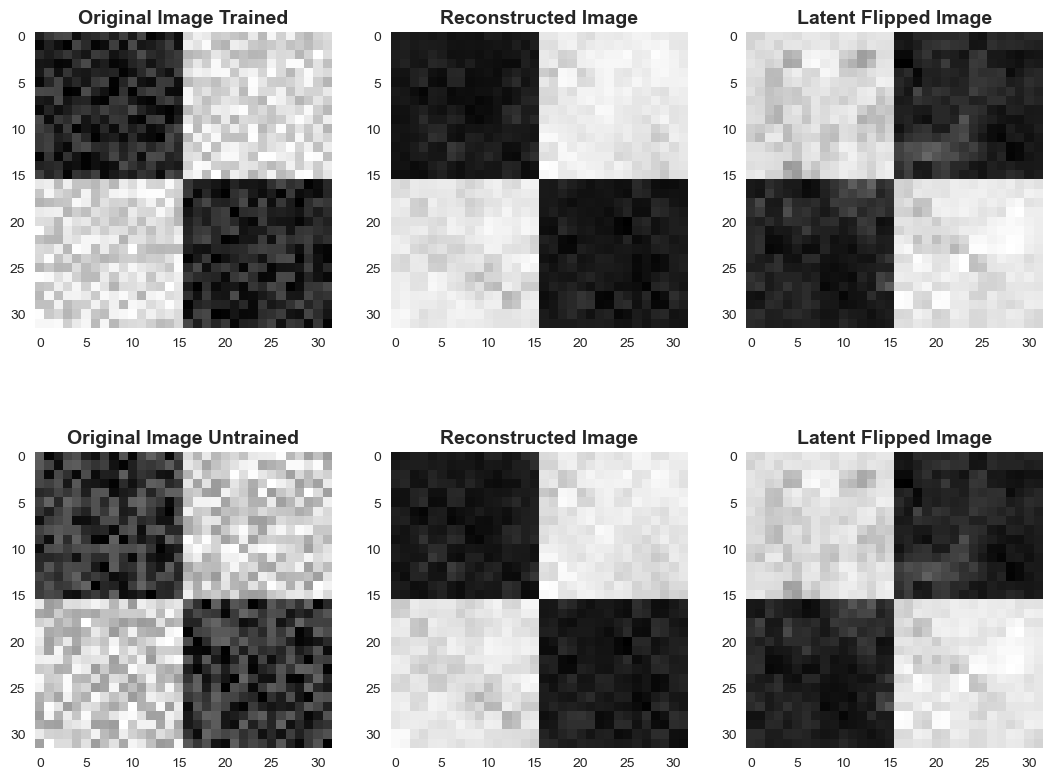

In [17]:
# Plot Two Example of Latent Tansformer 

i_trained = 173
i_untrained = 80

image_dim = 32

with torch.no_grad():
    model.eval()
    x_hat,z,_ = model(x_train[i_trained].reshape(1,1,image_dim,image_dim).to(device))
    z_hat_flip = model.Laug(z)
    x_hat_flip = model.decoder(z_hat_flip)

    x_hat_2,z_2,_ = model(x_test[i_untrained].reshape(1,1,image_dim,image_dim).to(device))
    z_hat_flip_2 = model.Laug(z_2)
    x_hat_flip_2 = model.decoder(z_hat_flip_2)

plt.figure(figsize=(13,10))

plt.subplot(2,3,1)
plt.grid(False)
plt.imshow(x_train[i_trained].reshape(image_dim,image_dim).cpu().detach().numpy(),cmap='gray')
plt.title('Original Image Trained', fontsize=14, fontweight='bold')
plt.subplot(2,3,2)
plt.grid(False)
plt.imshow(x_hat.reshape(image_dim,image_dim).cpu().detach().numpy(),cmap='gray')
plt.title('Reconstructed Image', fontsize=14, fontweight='bold')
plt.subplot(2,3,3)
plt.grid(False)
plt.imshow(x_hat_flip.reshape(image_dim,image_dim).cpu().detach().numpy(),cmap='gray')
plt.title('Latent Flipped Image', fontsize=14, fontweight='bold')

plt.subplot(2,3,4)
plt.grid(False)
plt.imshow(x_test[i_untrained].reshape(image_dim,image_dim).cpu().detach().numpy(),cmap='gray')
plt.title('Original Image Untrained', fontsize=14, fontweight='bold')
plt.subplot(2,3,5)
plt.grid(False)
plt.imshow(x_hat_2.reshape(image_dim,image_dim).cpu().detach().numpy(),cmap='gray')
plt.title('Reconstructed Image', fontsize=14, fontweight='bold')
plt.subplot(2,3,6)
plt.grid(False)
plt.imshow(x_hat_flip_2.reshape(image_dim,image_dim).cpu().detach().numpy(),cmap='gray')
plt.title('Latent Flipped Image', fontsize=14, fontweight='bold')


In [8]:
z_hat_flip, z_hat_flip_2

(tensor([[-1.5549, -1.8806]]), tensor([[0.3307, 1.5110]]))